In [1]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

2021-11-30 12:32:14.137327: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-11-30 12:32:14.157716: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 12:32:14.157981: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.71GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2021-11-30 12:32:14.158108: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-11-30 12:32:14.159280: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-11-30 12:32:14.160262: I tensorflow/stream_executor/platform/de

# Custom networks with keras and Deterministic Policy Gradient (DPG)

In this tutorial we introduce an advanced procedure to define your custom neural network using keras. This procedure allows the user to create more complex neural architectures and use all kind of layers from keras module.

We choose Deterministic Policy Gradient (DPG) which is a Policy-Based agent, this means that the agent will learn the policy itself. Instead of proposing values of states V(s) as DQN based angen do, DPG propose directly the actions.

In [2]:
from RL_Problem import rl_problem
from RL_Agent import dpg_agent
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from RL_Agent.base.utils.networks import networks
from RL_Agent.base.utils import agent_saver, history_utils
import gym

2021-11-30 12:32:15.916388: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2021-11-30 12:32:15.937721: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 3199980000 Hz
2021-11-30 12:32:15.938096: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x562e1ac6c120 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-11-30 12:32:15.938108: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-11-30 12:32:15.938247: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 12:32:15.938513: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeF

In file "RL_Agent.base.utils.networks.networks" we have some functions to define the dictionaries with the neural network architectures. These dictionaries have a key called: use_custom_network. 

When this key is set to True, the agent will spect a funtion that build a keras model. This function receives the input shape of the network which should be the state size. Inside this function you can create you keras network and return it as a tensorflow.keras.models.Sequential or as from tensorflow.keras.models.Model. 

The next cell shows an example of creating a Sequential keras model.

In [3]:
def lstm_custom_model(input_shape):
    actor_model = Sequential()
    actor_model.add(LSTM(64, input_shape=input_shape, activation='tanh'))
    actor_model.add(Dense(256, input_shape=input_shape, activation='relu'))
    actor_model.add(Dense(256, activation='relu'))
    return actor_model

Then, we need to define the dictionary to especify the network architecture. As explained before, use_custom_network params has to be set to True. The other param, "custom_network", recieves the function to build the model. 

For this particular case, we only have the "custom_network" param, but in other cases we may have the network divided in subnetworks. For example, Dueling DDQN or Deep Deterministic Policy Gradient have especific network architectures that are divided in subnerworks where we have an especific key in the dictionarie for each subnetwork.

In [4]:
net_architecture = networks.dpg_net(use_custom_network=True,
                                    custom_network=lstm_custom_model)

Here we define the RL agent that we are going to use.

* learning_rate: learning rate for training the neural network.
* batch_size: Size of the batches used for training the neural network. 
* net_architecture: net architecture defined before.
* n_stack: number of stacked timesteps to form the state.

You may notice that we do not include parameters related to exploration process like "epsilon", this is because this algorithm use by default a random choice of action based on the probabilities calculated by the neural network (np.random.choice(n_actions, p=probability_predicitons). This dotes DPG with an inherent explorative behavior and makes epsilon (exploration rate) not needed.

In [5]:
agent = dpg_agent.Agent(learning_rate=1e-3,
                        batch_size=64,
                        net_architecture=net_architecture,
                        n_stack=5)

We chose the LunarLander environment from OpenAI Gym.

In [6]:
environment = "LunarLander-v2"
environment = gym.make(environment)

Create a RL problem were the comunications between agent and environment are managed. In this case, we use the funcionality from "RL_Problem.rl_problem" which makes transparent to the user the selection of the matching problem. The function "Problem" automaticaly selects the problem based on the agent used.

In [7]:
problem = rl_problem.Problem(environment, agent)

Next step is solving the RL problem that we have define. Here we specify the number of episodes, the skip_states parameter, the render boolean and additionaly after how many iterations we want to render the environment. 

When render is set to False we can specify the render_after parameter. The environement will be rendering after reach the specified number of iterations.

In [8]:
problem.solve(episodes=250, skip_states=3, render=False, render_after=200)

2021-11-30 12:32:21.289300: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-11-30 12:32:21.478313: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


Episode:  1 Epochs:  85  Reward: -381.6 Smooth Reward: -381.6  Epsilon: 0.0000
Episode:  2 Epochs:  107  Reward: -263.0 Smooth Reward: -322.3  Epsilon: 0.0000
Episode:  3 Epochs:  91  Reward: -498.7 Smooth Reward: -381.1  Epsilon: 0.0000
Episode:  4 Epochs:  140  Reward: -266.9 Smooth Reward: -352.6  Epsilon: 0.0000
Episode:  5 Epochs:  109  Reward: -253.1 Smooth Reward: -332.7  Epsilon: 0.0000
Episode:  6 Epochs:  118  Reward: -144.2 Smooth Reward: -301.2  Epsilon: 0.0000
Episode:  7 Epochs:  74  Reward: -154.0 Smooth Reward: -280.2  Epsilon: 0.0000
Episode:  8 Epochs:  87  Reward: -174.8 Smooth Reward: -267.0  Epsilon: 0.0000
Episode:  9 Epochs:  83  Reward: -150.0 Smooth Reward: -254.0  Epsilon: 0.0000
Episode:  10 Epochs:  76  Reward: -319.0 Smooth Reward: -260.5  Epsilon: 0.0000
Episode:  11 Epochs:  121  Reward: -239.2 Smooth Reward: -246.3  Epsilon: 0.0000
Episode:  12 Epochs:  111  Reward: -200.1 Smooth Reward: -240.0  Epsilon: 0.0000
Episode:  13 Epochs:  80  Reward: -98.2 Smo

Episode:  105 Epochs:  127  Reward: -81.6 Smooth Reward: -144.6  Epsilon: 0.0000
Episode:  106 Epochs:  230  Reward: -299.3 Smooth Reward: -167.1  Epsilon: 0.0000
Episode:  107 Epochs:  109  Reward: -12.0 Smooth Reward: -146.7  Epsilon: 0.0000
Episode:  108 Epochs:  107  Reward: -18.9 Smooth Reward: -154.5  Epsilon: 0.0000
Episode:  109 Epochs:  154  Reward: 33.9 Smooth Reward: -128.8  Epsilon: 0.0000
Episode:  110 Epochs:  84  Reward: -92.1 Smooth Reward: -115.1  Epsilon: 0.0000
Episode:  111 Epochs:  179  Reward: -101.6 Smooth Reward: -99.2  Epsilon: 0.0000
Episode:  112 Epochs:  406  Reward: -93.5 Smooth Reward: -97.2  Epsilon: 0.0000
Episode:  113 Epochs:  100  Reward: -164.4 Smooth Reward: -89.6  Epsilon: 0.0000
Episode:  114 Epochs:  200  Reward: -383.5 Smooth Reward: -121.3  Epsilon: 0.0000
Episode:  115 Epochs:  76  Reward: -192.4 Smooth Reward: -132.4  Epsilon: 0.0000
Episode:  116 Epochs:  88  Reward: -53.6 Smooth Reward: -107.8  Epsilon: 0.0000
Episode:  117 Epochs:  86  Rew

Episode:  209 Epochs:  196  Reward: -10.7 Smooth Reward: 54.2  Epsilon: 0.0000
Episode:  210 Epochs:  114  Reward: -28.7 Smooth Reward: 52.3  Epsilon: 0.0000
Episode:  211 Epochs:  104  Reward: -27.8 Smooth Reward: 48.2  Epsilon: 0.0000
Episode:  212 Epochs:  103  Reward: 7.1 Smooth Reward: 47.0  Epsilon: 0.0000
Episode:  213 Epochs:  69  Reward: -58.8 Smooth Reward: 38.2  Epsilon: 0.0000
Episode:  214 Epochs:  100  Reward: -47.9 Smooth Reward: 22.5  Epsilon: 0.0000
Episode:  215 Epochs:  107  Reward: -55.4 Smooth Reward: -6.3  Epsilon: 0.0000
Episode:  216 Epochs:  101  Reward: -50.1 Smooth Reward: -36.5  Epsilon: 0.0000
Episode:  217 Epochs:  116  Reward: 10.0 Smooth Reward: -38.7  Epsilon: 0.0000
Episode:  218 Epochs:  93  Reward: 48.9 Smooth Reward: -21.3  Epsilon: 0.0000
Episode:  219 Epochs:  148  Reward: -1.5 Smooth Reward: -20.4  Epsilon: 0.0000
Episode:  220 Epochs:  126  Reward: -45.3 Smooth Reward: -22.1  Epsilon: 0.0000
Episode:  221 Epochs:  86  Reward: -64.1 Smooth Reward

Runing the agent in exploitation mode over the environment to see the final performance.

In [9]:
problem.test(n_iter=4, render=True)

Test episode:  1 Epochs:  131  Reward: 17.4 Smooth Reward: 17.4  Epsilon: 0.0000
Test episode:  2 Epochs:  164  Reward: 34.3 Smooth Reward: 25.8  Epsilon: 0.0000
Test episode:  3 Epochs:  132  Reward: 16.9 Smooth Reward: 22.9  Epsilon: 0.0000
Test episode:  4 Epochs:  142  Reward: -17.5 Smooth Reward: 12.8  Epsilon: 0.0000


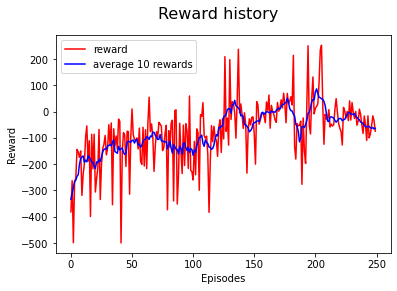

In [10]:
hist = problem.get_histogram_metrics()
history_utils.plot_reward_hist(hist, 10)

In [ ]:
agent_saver.save(agent, 'agent_dpg_lunar.json')